In [104]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

pd.set_option('display.max_columns', None)

np.random_state = 42

In [105]:
# load batting_basic
batting_basic = pd.read_csv('Data/batting_basic', index_col = 0)
batting_basic.head()

Season                Name POS Team   Age    Salary  Adjusted 2021 Salary  \
0  2000.0         Jeff Abbott  OF  CHW  27.0  255000.0              394926.0   
1  2000.0         Kurt Abbott  2B  NYM  31.0  500000.0              774365.0   
2  2006.0  Reggie Abercrombie  OF  MIA  24.0  327000.0              430203.0   
3  2001.0     Brent Abernathy  2B  TBR  23.0  215000.0              321031.0   
4  2002.0     Brent Abernathy  2B  TBR  24.0  215000.0              317237.0   

       G     AB     PA    AVG      H    1B    2B   3B   HR     R   RBI    BB  \
0   80.0  215.0  242.0  0.274   59.0  40.0  15.0  1.0  3.0  31.0  29.0  21.0   
1   79.0  157.0  173.0  0.217   34.0  20.0   7.0  1.0  6.0  22.0  12.0  14.0   
2  111.0  255.0  281.0  0.212   54.0  35.0  12.0  2.0  5.0  39.0  24.0  18.0   
3   79.0  304.0  335.0  0.270   82.0  59.0  17.0  1.0  5.0  43.0  33.0  27.0   
4  117.0  463.0  504.0  0.242  112.0  88.0  18.0  4.0  2.0  46.0  40.0  25.0   

   IBB    SO  HBP   SF   SH  GDP    SB   CS    OBP    SLG    OPS  
0  1.0  38.0  2.0  1.0  2.0  2.0   2.0  1.0  0.343  0.395  0.738  
1  2.0  51.0  1.0  1.0  0.0  2.0   1.0  1.0  0.283  0.389  0.672  
2  2.0  78.0  3.0  1.0  4.0  2.0   6.0  5.0  0.271  0.333  0.604  
3  1.0  35.0  0.0  1.0  3.0  3.0   8.0  3.0  0.328  0.382  0.710  
4  0.0  46.0  6.0  2.0  8.0  8.0  10.0  4.0  0.288  0.311  0.599

In [106]:
batting_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9139 entries, 0 to 9138
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Season                9139 non-null   float64
 1   Name                  9139 non-null   object 
 2   POS                   9139 non-null   object 
 3   Team                  9139 non-null   object 
 4   Age                   9139 non-null   float64
 5   Salary                9139 non-null   float64
 6   Adjusted 2021 Salary  9139 non-null   float64
 7   G                     9139 non-null   float64
 8   AB                    9139 non-null   float64
 9   PA                    9139 non-null   float64
 10  AVG                   9139 non-null   float64
 11  H                     9139 non-null   float64
 12  1B                    9139 non-null   float64
 13  2B                    9139 non-null   float64
 14  3B                    9139 non-null   float64
 15  HR                   

We likely dont need the following columns to determine our target variable of `Salary` so we can drop them moving forward:
- `Season`
- `Team`
- `Name`


In [107]:
batting_basic = batting_basic.drop(columns = ['Season', 'Name'])
batting_basic

POS Team   Age     Salary  Adjusted 2021 Salary      G     AB     PA  \
0     OF  CHW  27.0   255000.0              394926.0   80.0  215.0  242.0   
1     2B  NYM  31.0   500000.0              774365.0   79.0  157.0  173.0   
2     OF  MIA  24.0   327000.0              430203.0  111.0  255.0  281.0   
3     2B  TBR  23.0   215000.0              321031.0   79.0  304.0  335.0   
4     2B  TBR  24.0   215000.0              317237.0  117.0  463.0  504.0   
...   ..  ...   ...        ...                   ...    ...    ...    ...   
9134   C  SEA  25.0   523500.0              577574.0   55.0  164.0  192.0   
9135   C  SEA  26.0   570000.0              613477.0  124.0  387.0  435.0   
9136   C  SEA  27.0  2975000.0             3135948.0  113.0  373.0  405.0   
9137   C  TBR  28.0  4412000.0             4582035.0   90.0  266.0  289.0   
9138   C  TBR  30.0  2000000.0             2000000.0  109.0  333.0  375.0   

        AVG      H    1B    2B   3B    HR     R   RBI    BB  IBB     SO  HBP  \
0     0.274   59.0  40.0  15.0  1.0   3.0  31.0  29.0  21.0  1.0   38.0  2.0   
1     0.217   34.0  20.0   7.0  1.0   6.0  22.0  12.0  14.0  2.0   51.0  1.0   
2     0.212   54.0  35.0  12.0  2.0   5.0  39.0  24.0  18.0  2.0   78.0  3.0   
3     0.270   82.0  59.0  17.0  1.0   5.0  43.0  33.0  27.0  1.0   35.0  0.0   
4     0.242  112.0  88.0  18.0  4.0   2.0  46.0  40.0  25.0  0.0   46.0  6.0   
...     ...    ...   ...   ...  ...   ...   ...   ...   ...  ...    ...  ...   
9134  0.207   34.0  15.0   7.0  0.0  12.0  16.0  31.0  21.0  0.0   65.0  6.0   
9135  0.251   97.0  47.0  25.0  0.0  25.0  52.0  64.0  39.0  0.0  160.0  8.0   
9136  0.201   75.0  37.0  18.0  0.0  20.0  37.0  44.0  24.0  0.0  150.0  6.0   
9137  0.165   44.0  24.0  10.0  1.0   9.0  30.0  32.0  20.0  0.0   98.0  3.0   
9138  0.216   72.0  26.0  11.0  2.0  33.0  64.0  62.0  34.0  0.0  132.0  7.0   

       SF   SH  GDP    SB   CS    OBP    SLG    OPS  
0     1.0  2.0  2.0   2.0  1.0  0.343  0.395  0.738  
1     1.0  0.0  2.0   1.0  1.0  0.283  0.389  0.672  
2     1.0  4.0  2.0   6.0  5.0  0.271  0.333  0.604  
3     1.0  3.0  3.0   8.0  3.0  0.328  0.382  0.710  
4     2.0  8.0  8.0  10.0  4.0  0.288  0.311  0.599  
...   ...  ...  ...   ...  ...    ...    ...    ...  
9134  1.0  0.0  0.0   0.0  0.0  0.318  0.470  0.787  
9135  1.0  0.0  8.0   1.0  0.0  0.331  0.509  0.840  
9136  2.0  0.0  7.0   0.0  0.0  0.259  0.410  0.669  
9137  0.0  0.0  4.0   0.0  0.0  0.232  0.312  0.544  
9138  1.0  0.0  7.0   0.0  0.0  0.301  0.559  0.860  

[9139 rows x 28 columns]

In [108]:
batting_basic.describe()

Age        Salary  Adjusted 2021 Salary            G  \
count  9139.000000  9.139000e+03          9.139000e+03  9139.000000   
mean     28.715067  3.568462e+06          4.251747e+06   105.053179   
std       4.094207  5.041515e+06          5.818202e+06    38.362117   
min      19.000000  1.000000e+05          1.013600e+05    22.000000   
25%      26.000000  4.937500e+05          5.621665e+05    73.000000   
50%      28.000000  1.000000e+06          1.288851e+06   109.000000   
75%      31.000000  4.750000e+06          5.799564e+06   140.000000   
max      47.000000  3.766667e+07          4.082705e+07   163.000000   

                AB           PA          AVG            H           1B  \
count  9139.000000  9139.000000  9139.000000  9139.000000  9139.000000   
mean    345.338440   387.168071     0.256565    91.382865    59.728636   
std     166.064856   187.218150     0.035961    50.006902    33.347883   
min      80.000000   100.000000     0.101000     9.000000     3.000000   
25%     194.000000   216.000000     0.234000    47.000000    31.000000   
50%     335.000000   373.000000     0.258000    85.000000    56.000000   
75%     495.000000   555.000000     0.281000   133.000000    85.000000   
max     716.000000   778.000000     0.372000   262.000000   225.000000   

                2B           3B           HR            R          RBI  \
count  9139.000000  9139.000000  9139.000000  9139.000000  9139.000000   
mean     18.336032     1.881278    11.436919    47.476420    45.437794   
std      11.067230     2.232105     9.989480    28.476543    29.262425   
min       0.000000     0.000000     0.000000     2.000000     0.000000   
25%       9.000000     0.000000     4.000000    23.000000    21.000000   
50%      17.000000     1.000000     8.000000    42.000000    39.000000   
75%      26.000000     3.000000    16.000000    68.000000    64.000000   
max      59.000000    23.000000    73.000000   152.000000   160.000000   

                BB          IBB           SO          HBP           SF  \
count  9139.000000  9139.000000  9139.000000  9139.000000  9139.000000   
mean     33.600175     2.487362    70.776453     3.697122     2.787723   
std      23.085520     3.968624    37.476334     3.717150     2.375648   
min       1.000000     0.000000     4.000000     0.000000     0.000000   
25%      16.000000     0.000000    41.000000     1.000000     1.000000   
50%      28.000000     1.000000    64.000000     3.000000     2.000000   
75%      46.000000     3.000000    95.000000     5.000000     4.000000   
max     232.000000   120.000000   223.000000    31.000000    16.000000   

                SH          GDP           SB           CS          OBP  \
count  9139.000000  9139.000000  9139.000000  9139.000000  9139.000000   
mean      1.684867     7.834336     5.862458     2.293139     0.324812   
std       2.611749     5.423609     8.569531     2.757343     0.041144   
min       0.000000     0.000000     0.000000     0.000000     0.162000   
25%       0.000000     4.000000     1.000000     0.000000     0.299000   
50%       1.000000     7.000000     3.000000     1.000000     0.325000   
75%       2.000000    11.000000     7.000000     3.000000     0.351000   
max      24.000000    32.000000    78.000000    24.000000     0.609000   

               SLG          OPS  
count  9139.000000  9139.000000  
mean      0.410912     0.735718  
std       0.080102     0.112796  
min       0.144000     0.322000  
25%       0.356000     0.663000  
50%       0.407000     0.732000  
75%       0.461000     0.805000  
max       0.863000     1.422000

## Visualizing Distribution Of Batter Salaries by Position

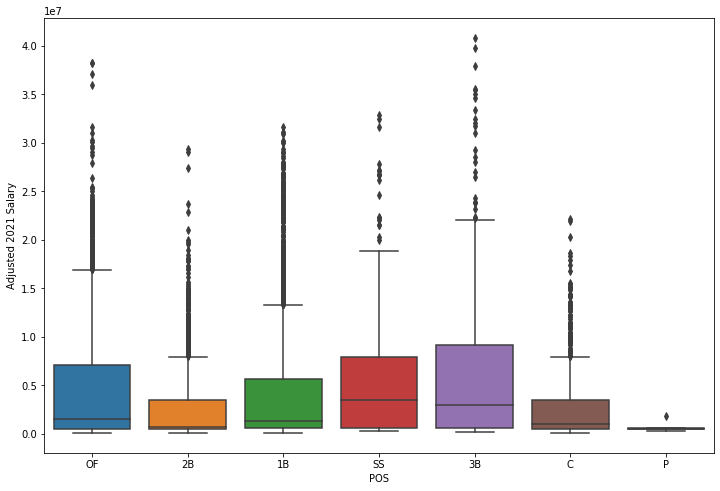

In [109]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(x='POS',   # change by column to see distribution of other features
            y='Adjusted 2021 Salary', 
            data=batting_basic)

plt.show()

## Visualizing Relationship of Statistics with Salary

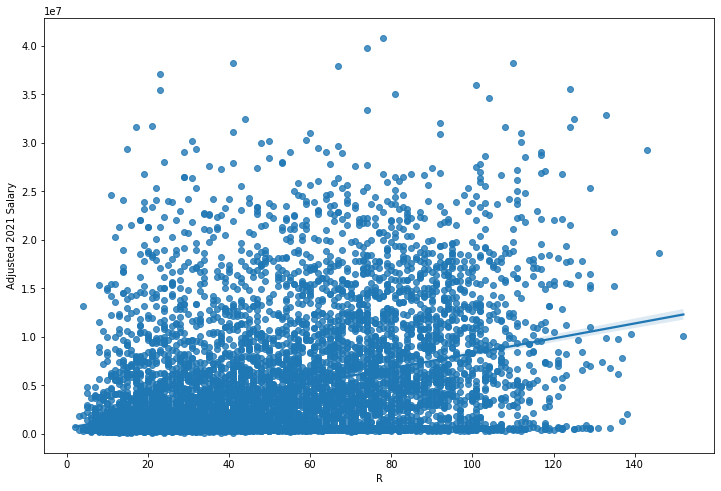

In [110]:
fig, ax = plt.subplots(figsize = (12,8))

sns.regplot(x='R',   # change by column to see distribution of other features
            y='Adjusted 2021 Salary', 
            data=batting_basic)

plt.show()

## Visualize the Distribution of the Target Variable `Salary`

Prior to performing a train-test split, lets first look at the distribution of the target variable salary.

In [111]:
batting_salaries = batting_basic['Salary']

skewness: 2.2553163797033413
kurtosis: 5.660409608328505


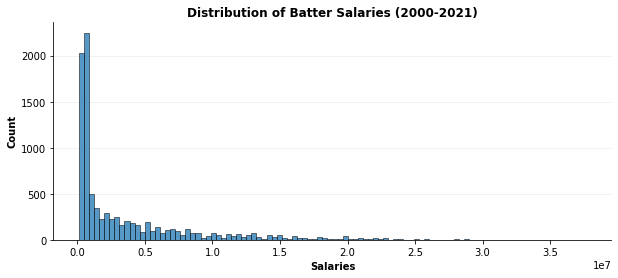

In [112]:
# plot dist of price
fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(batting_salaries, bins=100)

# removes top and right side axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set gridline visibility
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel("Salaries", weight = 'bold')
ax.set_ylabel("Count", weight = 'bold')
ax.set_title("Distribution of Batter Salaries (2000-2021)", weight = 'bold')

print('skewness:', skew(batting_salaries))
print('kurtosis:', kurtosis(batting_salaries));

Based on this distribution we can conclude the following:

- The distribution of salaries for batters is highly positively skewed with a long right tail due to outliers.

- Most batters make under $500,000

We will scale the target variable salary using a log function to have a more normalized distribution after we train-test split.

## Train-Test Split

In [129]:
# feature selection, target variable = 'Salary'
X = batting_basic.drop(['Adjusted 2021 Salary', 'Salary'], axis = 1)
y = batting_basic['Adjusted 2021 Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [130]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6854, 26)
(2285, 26)
(6854,)
(2285,)


## Define the Preprocessing Pipelines

Steps for preprocessing the data are as follows:

- One hot encode the categorical features; we only have two (2) categoricals: `POS` and `Team`


- Standard Scale the numerical features

In [131]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [132]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) # apply a standard scaler

# define a nominal transformation pipeline that OHE the cats, and MaxAbsScales the set
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories="auto", # ohe the cat variables
                                                         sparse = False))]) 

In [133]:
# transform the selected columns with nominal, and numeric pipelines
bb_ct = ColumnTransformer(transformers = 
                    [("nominalpipe", nominal_pipeline, cat_cols), 
                     ("numpipe", numeric_pipeline, num_cols)])

### Pickle the Transformer

In [134]:
# save the transformer
dump(bb_ct, open('pkl/bb_ct.pkl', 'wb'))

In [135]:
# load the transformer
bb_ct = load(open('pkl/bb_ct.pkl', 'rb'))

In [136]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_bb_X_train = pd.DataFrame(bb_ct.fit_transform(X_train))
pp_bb_X_train.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

    30   31   32   33   34   35   36        37        38        39        40  \
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.308498 -0.104159 -1.057699 -1.043491   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0 -0.917267  1.484496  1.922417  1.887449   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.553651 -0.260420 -0.321719 -0.358892   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.553651  1.093843  1.415677  1.261683   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.553651  0.911538 -0.689709 -0.503300   

         41        42        43        44        45        46        47  \
0 -1.404504 -1.128853 -0.955744 -1.114357 -0.387879 -1.144360 -0.789194   
1  0.401421  1.774726  2.063652  0.772518  1.835339  0.755409  1.949165   
2 -1.321154 -0.608211 -0.653804 -0.036142 -0.832523 -0.644421 -0.613658   
3  0.679256  1.434307  1.640936  1.042072 -0.387879  0.655421  1.352343   
4 -0.404299 -0.708335 -0.834968 -0.754952 -0.387879  0.155482 -0.087051   

         48        49        50        51        52        53        54  \
0 -1.207010 -0.889137 -0.117948 -0.986358 -0.454876 -1.173483  2.080911   
1  0.936743  1.529448  0.129350  1.637258  0.355763 -1.173483  0.134282   
2 -0.900759 -0.543625 -0.365246 -0.397383 -0.184663 -0.752183  0.523608   
3  1.072855 -0.241301 -0.117948  0.218364  1.166403  0.511720  0.523608   
4 -0.118119  1.097558  0.376647 -0.102895 -0.184663 -1.173483 -0.644370   

         55        56        57        58        59        60  
0 -0.520379 -0.100567 -0.099890 -1.326959 -1.965143 -1.878270  
1 -0.153983  4.315700  2.462968  0.469215  0.062888  0.215500  
2 -0.153983 -0.565437 -0.099890 -1.375504 -1.106651 -1.286361  
3  2.044389  1.061608 -0.099890 -0.089055  0.224633  0.127155  
4  0.212412 -0.565437 -0.466013  1.901300  0.647658  1.151954

In [137]:
pp_bb_X_train.shape

(6854, 61)

Now lets do the same transformation for the `X_test`

In [138]:
# inspect the preprocessed batting basic X train aka pp_bb_X_test
pp_bb_X_test = pd.DataFrame(bb_ct.transform(X_test))
pp_bb_X_test.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    30   31   32   33   34   35   36        37        38        39        40  \
0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 -0.181808  0.885495  0.854643  0.844505   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.308498  0.963626  1.439807  1.416787   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.289109 -1.510509 -1.087863 -1.096976   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.672114  0.026059 -0.388078 -0.417725   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.308498 -0.182289 -0.442372 -0.465861   

         41        42        43        44        45        46        47  \
0  1.207142  1.093887  1.218221  1.311625  1.835339 -0.444445  0.509771   
1  1.096008  1.634554  2.486367  0.323262  1.835339 -0.844397  1.282129   
2  0.290287 -0.948631 -0.714192 -0.934654 -0.832523 -1.144360 -1.245587   
3 -1.404504 -0.668285 -0.623610 -0.305696 -0.832523 -0.744409 -0.473230   
4 -0.376516 -0.508088 -0.261283 -0.934654 -0.832523 -0.444445 -0.789194   

         48        49        50        51        52        53        54  \
0  0.528409  0.147400  0.376647  0.673481  1.436616  3.039525  0.134282   
1  0.120075  0.967991 -0.612543 -0.343839 -0.725089 -0.330882  2.859563   
2 -1.241038 -1.105082 -0.612543 -1.093444 -0.184663 -0.752183  1.302259   
3 -0.798676 -0.414058  0.376647  0.111277 -0.454876 -0.330882 -0.644370   
4 -0.458398 -0.414058  0.623945 -0.691870 -0.725089  0.090419 -0.644370   

         55        56        57        58        59        60  
0  0.578807  1.177826  0.632355  0.711942  0.299285  0.471700  
1  1.128401  2.223784  3.195213  0.809032 -0.509440 -0.067203  
2 -1.253170 -0.681655 -0.832136 -0.331781 -1.193745 -0.968320  
3 -0.703577  0.596738  0.632355 -1.278414 -1.355490 -1.427712  
4 -0.153983 -0.681655  0.632355 -0.525962 -0.770720 -0.729789

In [139]:
pp_bb_X_test.shape

(2285, 61)

For convenience, we'll need to know the names of our columns after preprocessing and the columns or features that are most important during the modeling. 

Below is code to get those feature names after preprocessing the columns.

In [140]:
# check length of each OHE cat features
print(len(X_train['POS'].unique()))
print(len(X_train['Team'].unique()))
print("Total # of Categoricals:", len(X_train['POS'].unique()) + len(X_train['Team'].unique()))

7
30
Total # of Categoricals: 37


In [141]:
# get feature names after encoding
cat_feature_names = list(nominal_pipeline.named_steps['onehotenc'].fit(X_train[cat_cols]).get_feature_names())

# confirm length of feature names
len(cat_feature_names)

/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


37

In [142]:
# removes the OHE strings at front end of feature names
def clean_features(lst):
    new_list = []
    for value in lst:
        splitted = value.split('_')[1] # returns name of feature after '_'
        new_list.append(splitted)
        continue
    return new_list

In [143]:
# clean the categorical feature names
cat_feature_names = clean_features(cat_feature_names)

In [144]:
# preview
cat_feature_names[0:10]

['1B', '2B', '3B', 'C', 'OF', 'P', 'SS', 'ARI', 'ATL', 'BAL']

In [145]:
# get numerical feature names
num_features_names = list(num_cols)

In [146]:
# preview
num_features_names[0:10]

['Age', 'G', 'AB', 'PA', 'AVG', 'H', '1B', '2B', '3B', 'HR']

In [147]:
# put into a dataframe
feature_names_df = pd.DataFrame(cat_feature_names)

# add the numerical cols at end of dataframe
feature_names_df = feature_names_df.append(num_features_names)

/var/folders/m4/85rmk51d0pd2_q6_wp0vplz40000gn/T/ipykernel_14814/638970588.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_names_df = feature_names_df.append(num_features_names)


In [148]:
# check
feature_names_df.tail(20)

0
4   AVG
5     H
6    1B
7    2B
8    3B
9    HR
10    R
11  RBI
12   BB
13  IBB
14   SO
15  HBP
16   SF
17   SH
18  GDP
19   SB
20   CS
21  OBP
22  SLG
23  OPS

**Log Transforming Salary**

As observed earlier, since the target variable salary is not normally distributed, we will want to create a more normalized distribution by log transforming. 

In [149]:
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

skewness: 0.4332029539475566
kurtosis: -1.1942233094504366


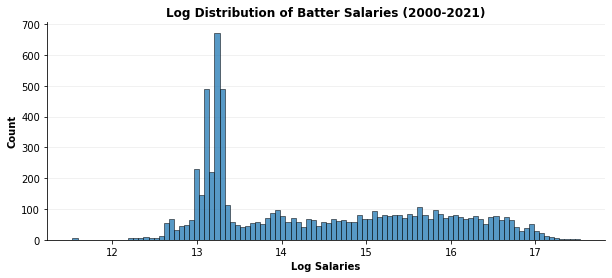

In [150]:
# plot dist of price
fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(log_y_train, bins=100)

# removes top and right side axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set gridline visibility
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel("Log Salaries", weight = 'bold')
ax.set_ylabel("Count", weight = 'bold')
ax.set_title("Log Distribution of Batter Salaries (2000-2021)", weight = 'bold')

print('skewness:', skew(log_y_train))
print('kurtosis:', kurtosis(log_y_train));

# Establish Simple Baseline Models

### Metrics

In [151]:
# create function that gives performance metrics
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(np.exp(y_true), np.exp(y_predict), squared = False) # False gives RMSE

    # Return the score
    return [r2, rmse]

### Cross Validation - 5 Folds

In [152]:
# define a simple function that returns cross validation score for a 5 fold
def get_cv_score(model, X, y):
    
    # R2 score CV
    cv_r2_score = np.mean(cross_val_score(model, 
                                       X, y, 
                                       scoring = 'r2', 
                                       cv = 5))
    # RMSE score CV
    cv_rmse_score = np.mean(cross_val_score(model,
                                           X,
                                           np.exp(y),
                                           scoring = 'neg_root_mean_squared_error',
                                           cv = 5))
    
    print(model,"Cross Validation R2:      ",round(cv_r2_score, 4))
    print(model,"Cross Validation RMSE:   ",-round(cv_rmse_score))

### Linear Regression Model

In [153]:
# instantiate the linear regression model
lr_model = LinearRegression()
lr_model

# Fit our model
lr_model.fit(pp_bb_X_train, log_y_train)

# Make predictions on the training and test data
y_pred_train = lr_model.predict(pp_bb_X_train)
y_pred_test = lr_model.predict(pp_bb_X_test)

# Calculate performance using the performance() function 
train_scores = performance(log_y_train, y_pred_train)
test_scores = performance(log_y_test, y_pred_test)

# Training
print(lr_model, 'Training R2:              ', round(train_scores[0],4)) # R2
print(lr_model, 'Test R2:                  ', round(test_scores[0],4)) # R2
print('-----' * 11)
# Validation
get_cv_score(lr_model, pp_bb_X_train, log_y_train)
print('-----' * 11)
# Testing
print(lr_model, 'Training RMSE:           ', round(train_scores[1])) # RMSE
print(lr_model, 'Model Test RMSE:         ', round(test_scores[1])) # RMSE

LinearRegression() Training R2:               0.5566
LinearRegression() Test R2:                   0.5397
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5483
LinearRegression() Cross Validation RMSE:    4200223
-------------------------------------------------------
LinearRegression() Training RMSE:            6937946
LinearRegression() Model Test RMSE:          5264961


#### Get Model Results

To streamline the process of getting model results, below is a helper function that performs all the steps above and produces model training, cross validation, and testing results. 

In [154]:
def model_results(model, X_train, y_train, X_test, y_test):
    """
    Helper function that takes input of model, and train-test split sets 
    and returns the model R2, RMSE scores
    """
    # fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the training and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate performance using the performance() function 
    train_scores = performance(y_train, y_pred_train)
    test_scores = performance(y_test, y_pred_test)

    # Training
    print(" "*12, model, "RESULTS")
    print(model, 'Training R2:              ', round(train_scores[0],4)) # R2
    print(model, 'Test R2:                  ', round(test_scores[0],4)) # R2
    print('-----' * 11)
    # Validation
    get_cv_score(model, X_train, y_train)
    print('-----' * 11)
    # Testing
    print(model, 'Training RMSE:           ', round(train_scores[1])) # RMSE
    print(model, 'Test RMSE:               ', round(test_scores[1])) # RMSE

In [155]:
# Test of the model_results function
lr_model = LinearRegression()
model_results(lr_model, pp_bb_X_train, log_y_train, pp_bb_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.5566
LinearRegression() Test R2:                   0.5397
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5483
LinearRegression() Cross Validation RMSE:    4200223
-------------------------------------------------------
LinearRegression() Training RMSE:            6937946
LinearRegression() Test RMSE:                5264961


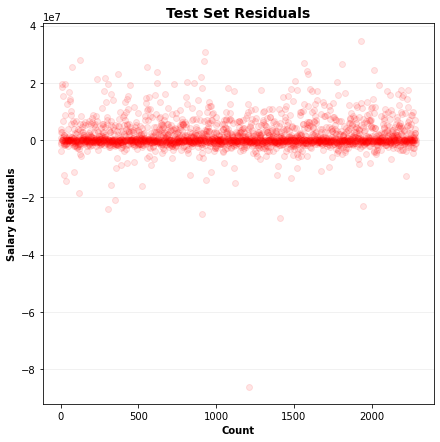

In [156]:
# get residuals plot
resid = y_test - np.exp(y_pred_test)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x = range(y_pred_test.shape[0]), y = resid, alpha = 0.1, c = 'red')

# residual labels
ax.set_xlabel('Count', weight = 'bold') 
ax.set_ylabel('Salary Residuals', weight = 'bold') 
ax.set_title('Test Set Residuals', weight = 'bold', fontdict = {'fontsize' : 14})

# set gridline visibility
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

plt.show()

**Pickle the `model_results` function**

In [157]:
# save the helper function
dump(model_results, open('pkl/model_results.pkl', 'wb'))

In [158]:
# load the model results function
get_results = load(open('pkl/model_results.pkl', 'rb'))

In [159]:
get_results(lr_model, pp_bb_X_train, log_y_train, pp_bb_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.5566
LinearRegression() Test R2:                   0.5397
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5483
LinearRegression() Cross Validation RMSE:    4200223
-------------------------------------------------------
LinearRegression() Training RMSE:            6937946
LinearRegression() Test RMSE:                5264961


**The above is a general workflow for preprocessing and performing a baseline model for the `batting_basic` table. For continued modeling, see the various Modeling notebooks in the Github Repository**

In [160]:
# code for getting feature importances after modeling
def plot_feature_importances(model):
    n_features = pp_bb_X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), pp_bb_X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(lr_model)

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

<Figure size 576x576 with 0 Axes>